In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
import glob
import statsmodels.api as sm

# Import your model functions (make sure your module paths are correct)
from models.utils import load_data, newey_west_tstat
from models.ols_model import OLSModel
from models.random_walk_model import RandomWalkModel
from models.lasso_model import LassoModel
from models.ridge_model import RidgeModel
from models.rf_model import RFModel
from models.gbf_model import GBFModel
from models.ar_model import ARModel
from models.hvz_model import HVZModel
from models.ri_model import RIModel
from models.xgb_model import XGBModel
from models.lightgbm_model import LightGBMModel
from models.catboost_model import CatBoostModel
from models.ann_model import ANNBaggingModel

# Set seaborn style
sns.set(style="whitegrid")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
def run_all_models(df, results_dir="full_results"):
    """Runs all models and saves results."""
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    models = [
        OLSModel(),
        RandomWalkModel(),
        ARModel(),
        HVZModel(),
        RIModel(),
        LassoModel(),
        RidgeModel(),
        RFModel(),
        GBFModel(),
        XGBModel(),
        LightGBMModel(),
        CatBoostModel(),
        ANNBaggingModel()
    ]

    for model in models:
        print(f"Running {model.name}...")
        df_forecasts = model.run_forecast(df)
        filepath = os.path.join(results_dir, f"{model.name}_forecasts.csv")
        df_forecasts.to_csv(filepath, index=False)
        print(f"  Saved results to {filepath}")

def load_merge_results(results_dir="full_results"):
    """Loads results from all model CSV files and merges them."""
    df_merged = None
    model_cols = {
        "ols": ["gvkey", "forecast_year", "mkt_cap", "E", "E_future", "abs_error_ols_scaled"],
        "ann": ["gvkey", "forecast_year", "abs_error_ann_bagging_scaled"],
        "ar": ["gvkey", "forecast_year", "abs_error_ar_scaled"],
        "catboost": ["gvkey", "forecast_year", "abs_error_catboost_scaled"],
        "gbf": ["gvkey", "forecast_year", "abs_error_gbf_scaled"],
        "hvz": ["gvkey", "forecast_year", "abs_error_hvz_scaled"],
        "lasso": ["gvkey", "forecast_year", "abs_error_lasso_scaled"],
        "lightgbm": ["gvkey", "forecast_year", "abs_error_lightgbm_scaled"],
        "rf": ["gvkey", "forecast_year", "abs_error_rf_scaled"],
        "ri": ["gvkey", "forecast_year", "abs_error_ri_scaled"],
        "ridge": ["gvkey", "forecast_year", "abs_error_ridge_scaled"],
        "rw": ["gvkey", "forecast_year", "E_pred_rw", "abs_error_rw_scaled"],
        "xgb": ["gvkey", "forecast_year", "abs_error_xgb_scaled"]
    }

    for filename in os.listdir(results_dir):
        if filename.endswith("_forecasts.csv"):
            model_name = filename.replace("_forecasts.csv", "")
            filepath = os.path.join(results_dir, filename)
            usecols = model_cols.get(model_name)
            if usecols is None:
                print(f"Warning: No columns defined for model '{model_name}'. Skipping file '{filename}'.")
                continue
            try:
                df_current = pd.read_csv(filepath, usecols=usecols)
            except ValueError as e:
                print(f"Error reading file '{filename}': {e}. Skipping file.")
                continue

            df_current.drop_duplicates(subset=["gvkey", "forecast_year"], keep="first", inplace=True)

            if df_merged is None:
                df_merged = df_current
            else:
                df_merged = df_merged.merge(df_current, on=["gvkey", "forecast_year"], how="left")

    return df_merged

def compute_summary_statistics(df_forecasts):
    """Computes and displays summary statistics."""
    grouped = df_forecasts.groupby('forecast_year').agg(
      abs_error_ols_mean     = ('abs_error_ols_scaled', 'mean'),
      abs_error_ols_median   = ('abs_error_ols_scaled', 'median'),
      abs_error_ar_mean      = ('abs_error_ar_scaled', 'mean'),
      abs_error_ar_median    = ('abs_error_ar_scaled', 'median'),
      abs_error_hvz_mean     = ('abs_error_hvz_scaled', 'mean'),
      abs_error_hvz_median   = ('abs_error_hvz_scaled', 'median'),
      abs_error_ri_mean      = ('abs_error_ri_scaled', 'mean'),
      abs_error_ri_median    = ('abs_error_ri_scaled', 'median'),
      abs_error_rw_mean      = ('abs_error_rw_scaled', 'mean'),
      abs_error_rw_median    = ('abs_error_rw_scaled', 'median'),
      abs_error_lasso_mean   = ('abs_error_lasso_scaled', 'mean'),
      abs_error_lasso_median = ('abs_error_lasso_scaled', 'median'),
      abs_error_ridge_mean   = ('abs_error_ridge_scaled', 'mean'),
      abs_error_ridge_median = ('abs_error_ridge_scaled', 'median'),
      abs_error_rf_mean      = ('abs_error_rf_scaled', 'mean'),
      abs_error_rf_median    = ('abs_error_rf_scaled', 'median'),
      abs_error_gbf_mean     = ('abs_error_gbf_scaled', 'mean'),
      abs_error_gbf_median   = ('abs_error_gbf_scaled', 'median'),
      abs_error_xgb_mean     = ('abs_error_xgb_scaled', 'mean'),
      abs_error_xgb_median   = ('abs_error_xgb_scaled', 'median'),
      abs_error_lgb_mean     = ('abs_error_lightgbm_scaled', 'mean'),
      abs_error_lgb_median   = ('abs_error_lightgbm_scaled', 'median'),
      abs_error_cb_mean      = ('abs_error_catboost_scaled', 'mean'),
      abs_error_cb_median    = ('abs_error_catboost_scaled', 'median'),
      abs_error_ann_mean     = ('abs_error_ann_bagging_scaled', 'mean'),
      abs_error_ann_median   = ('abs_error_ann_bagging_scaled', 'median')
    ).reset_index()

    display(grouped) 

    overall_results = pd.DataFrame({
        "Model": ["OLS", "AR", "HVZ", "RI", "Random Walk", "LASSO", "Ridge", "RF", "GBF", "XGB", "LGBM", "CB", "ANN"], 
        "Mean Absolute Forecast Error": [
            df_forecasts['abs_error_ols_scaled'].mean(),
            df_forecasts['abs_error_ar_scaled'].mean(),
            df_forecasts['abs_error_hvz_scaled'].mean(),
            df_forecasts['abs_error_ri_scaled'].mean(),
            df_forecasts['abs_error_rw_scaled'].mean(),
            df_forecasts['abs_error_lasso_scaled'].mean(),
            df_forecasts['abs_error_ridge_scaled'].mean(),
            df_forecasts['abs_error_rf_scaled'].mean(),
            df_forecasts['abs_error_gbf_scaled'].mean(),
            df_forecasts['abs_error_xgb_scaled'].mean(),
            df_forecasts['abs_error_lightgbm_scaled'].mean(),
            df_forecasts['abs_error_catboost_scaled'].mean(),
            df_forecasts['abs_error_ann_bagging_scaled'].mean()
        ],
        "Median Absolute Forecast Error": [
            df_forecasts['abs_error_ols_scaled'].median(),
            df_forecasts['abs_error_ar_scaled'].median(),
            df_forecasts['abs_error_hvz_scaled'].median(),
            df_forecasts['abs_error_ri_scaled'].median(),
            df_forecasts['abs_error_rw_scaled'].median(),
            df_forecasts['abs_error_lasso_scaled'].median(),
            df_forecasts['abs_error_ridge_scaled'].median(),
            df_forecasts['abs_error_rf_scaled'].median(),
            df_forecasts['abs_error_gbf_scaled'].median(),
            df_forecasts['abs_error_xgb_scaled'].median(),
            df_forecasts['abs_error_lightgbm_scaled'].median(),
            df_forecasts['abs_error_catboost_scaled'].median(),
            df_forecasts['abs_error_ann_bagging_scaled'].median()
        ]
    })

    display(overall_results)  

In [3]:
# df = load_data("data/prelim_fundamental_dataset.csv")
# run_all_models(df)

In [4]:
df_forecasts = load_merge_results()
# Exclude 2024 data
df_forecasts = df_forecasts[df_forecasts['forecast_year'] != 2024]
compute_summary_statistics(df_forecasts)

,forecast_year,abs_error_ols_mean,abs_error_ols_median,abs_error_ar_mean,abs_error_ar_median,abs_error_hvz_mean,abs_error_hvz_median,abs_error_ri_mean,abs_error_ri_median,abs_error_rw_mean,...,abs_error_gbf_mean,abs_error_gbf_median,abs_error_xgb_mean,abs_error_xgb_median,abs_error_lgb_mean,abs_error_lgb_median,abs_error_cb_mean,abs_error_cb_median,abs_error_ann_mean,abs_error_ann_median
0,1975,0.131164,0.056147,0.131275,0.050308,0.189295,0.090523,0.164750,0.077869,0.128881,...,0.125150,0.053973,0.137955,0.061748,0.124890,0.053399,0.131568,0.059105,0.129209,0.052504
1,1976,0.079888,0.035263,0.092824,0.041033,0.150394,0.059018,0.103166,0.043605,0.093046,...,0.073338,0.034818,0.084673,0.043830,0.074119,0.037434,0.079400,0.040553,0.075650,0.037417
2,1977,0.091602,0.037256,0.095483,0.035566,0.202132,0.075417,0.141611,0.051132,0.095733,...,0.079672,0.031290,0.095797,0.038912,0.080440,0.032273,0.084980,0.035600,0.085391,0.035997
3,1978,0.079569,0.037691,0.084690,0.034737,0.165935,0.060470,0.123356,0.040200,0.086368,...,0.069954,0.032461,0.081510,0.037665,0.071576,0.033718,0.075176,0.035581,0.073798,0.035964
4,1979,0.078939,0.037395,0.077069,0.034301,0.156681,0.058964,0.099834,0.036162,0.079030,...,0.072733,0.030867,0.079332,0.033566,0.072795,0.032734,0.077210,0.035260,0.076136,0.034923
5,1980,0.107300,0.043984,0.103232,0.039477,0.187156,0.072313,0.116617,0.042796,0.101026,...,0.102956,0.039079,0.108881,0.045146,0.101113,0.038704,0.104749,0.043201,0.102426,0.042419
6,1981,0.076133,0.029186,0.079545,0.029058,0.107996,0.037199,0.119313,0.038722,0.077997,...,0.074226,0.028743,0.077246,0.031015,0.073377,0.028511,0.077116,0.031578,0.075285,0.029879
7,1982,0.120874,0.051318,0.117686,0.046272,0.168412,0.075613,0.237870,0.083169,0.114434,...,0.121157,0.048656,0.122002,0.051150,0.116310,0.047801,0.118353,0.050841,0.119860,0.050062
8,1983,0.076332,0.029936,0.082303,0.029901,0.109231,0.041331,0.100729,0.039050,0.081646,...,0.074887,0.028446,0.077956,0.030865,0.074792,0.029856,0.075016,0.030905,0.072968,0.029528
9,1984,0.083883,0.030117,0.090709,0.032359,0.112308,0.040701,0.098921,0.033987,0.090572,...,0.078086,0.028554,0.082124,0.031152,0.078509,0.030253,0.081066,0.031830,0.080042,0.029642


,Model,Mean Absolute Forecast Error,Median Absolute Forecast Error
0,OLS,0.099828,0.037069
1,AR,0.088974,0.028802
2,HVZ,0.142469,0.042881
3,RI,0.134047,0.039839
4,Random Walk,0.089230,0.028955
5,LASSO,0.098136,0.036946
6,Ridge,0.097872,0.036539
7,RF,0.087878,0.028419
8,GBF,0.078098,0.026595
9,XGB,0.091001,0.032129


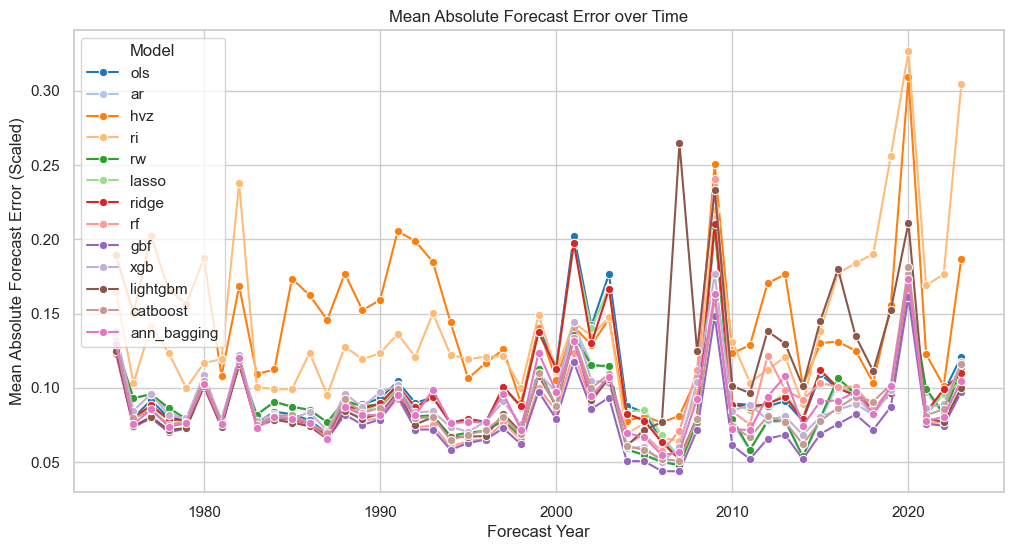

In [5]:
grouped_mean = df_forecasts.groupby("forecast_year").agg({
    "abs_error_ols_scaled": "mean",
    "abs_error_ar_scaled": "mean",
    "abs_error_hvz_scaled": "mean",
    "abs_error_ri_scaled": "mean",
    "abs_error_rw_scaled": "mean",
    "abs_error_lasso_scaled": "mean",
    "abs_error_ridge_scaled": "mean",
    "abs_error_rf_scaled": "mean",
    "abs_error_gbf_scaled": "mean",
    "abs_error_xgb_scaled": "mean",
    "abs_error_lightgbm_scaled": "mean",
    "abs_error_catboost_scaled": "mean",
    "abs_error_ann_bagging_scaled": "mean"
}).reset_index()

df_mean = pd.melt(grouped_mean, id_vars="forecast_year", 
                  var_name="model", value_name="mean_error")

df_mean["model"] = df_mean["model"].str.replace("abs_error_", "").str.replace("_scaled", "")

plt.figure(figsize=(12,6))
sns.lineplot(data=df_mean, x="forecast_year", y="mean_error", hue="model", marker="o", palette="tab20")
plt.title("Mean Absolute Forecast Error over Time")
plt.xlabel("Forecast Year")
plt.ylabel("Mean Absolute Forecast Error (Scaled)")
plt.legend(title="Model")
plt.show()

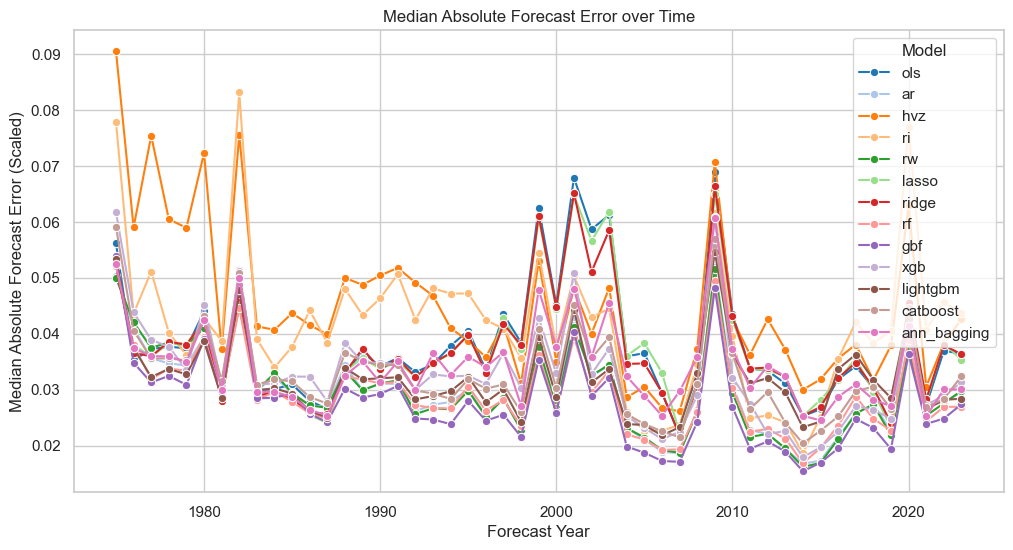

In [6]:
grouped_median = df_forecasts.groupby("forecast_year").agg({
    "abs_error_ols_scaled": "median",
    "abs_error_ar_scaled": "median",
    "abs_error_hvz_scaled": "median",
    "abs_error_ri_scaled": "median",
    "abs_error_rw_scaled": "median",
    "abs_error_lasso_scaled": "median",
    "abs_error_ridge_scaled": "median",
    "abs_error_rf_scaled": "median",
    "abs_error_gbf_scaled": "median",
    "abs_error_xgb_scaled": "median",
    "abs_error_lightgbm_scaled": "median",
    "abs_error_catboost_scaled": "median",
    "abs_error_ann_bagging_scaled": "median"
}).reset_index()

df_median = pd.melt(grouped_median, id_vars="forecast_year", 
                    var_name="model", value_name="median_error")
df_median["model"] = df_median["model"].str.replace("abs_error_", "").str.replace("_scaled", "")

plt.figure(figsize=(12,6))
sns.lineplot(data=df_median, x="forecast_year", y="median_error", hue="model", marker="o", palette="tab20")
plt.title("Median Absolute Forecast Error over Time")
plt.xlabel("Forecast Year")
plt.ylabel("Median Absolute Forecast Error (Scaled)")
plt.legend(title="Model")
plt.show()

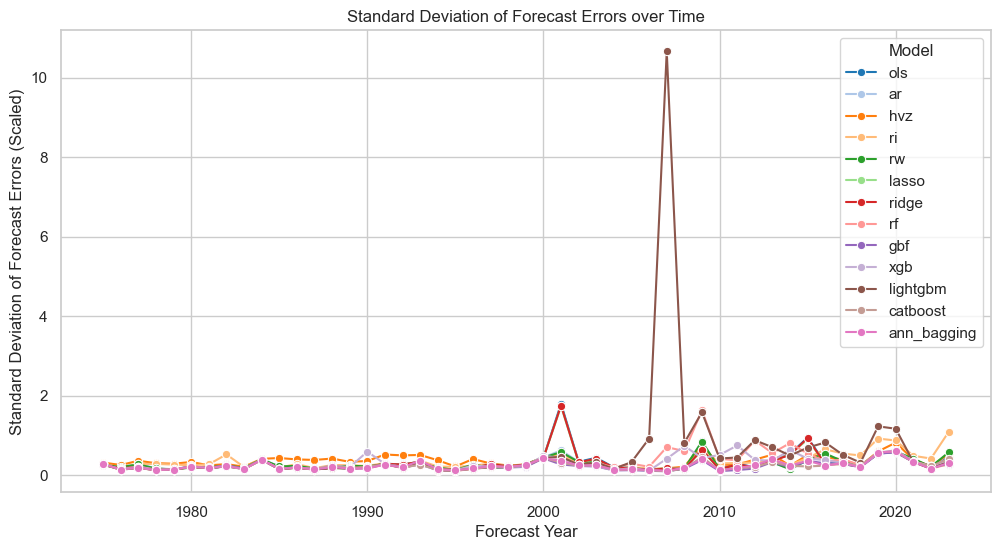

In [7]:
# Plot standard deviation of forecast errors
grouped_std = df_forecasts.groupby("forecast_year").agg({
    "abs_error_ols_scaled": "std",
    "abs_error_ar_scaled": "std",
    "abs_error_hvz_scaled": "std",
    "abs_error_ri_scaled": "std",
    "abs_error_rw_scaled": "std",
    "abs_error_lasso_scaled": "std",
    "abs_error_ridge_scaled": "std",
    "abs_error_rf_scaled": "std",
    "abs_error_gbf_scaled": "std",
    "abs_error_xgb_scaled": "std",
    "abs_error_lightgbm_scaled": "std",
    "abs_error_catboost_scaled": "std",
    "abs_error_ann_bagging_scaled": "std"
}).reset_index()

df_std = pd.melt(grouped_std, id_vars="forecast_year",
                    var_name="model", value_name="std_error")
df_std["model"] = df_std["model"].str.replace("abs_error_", "").str.replace("_scaled", "")

plt.figure(figsize=(12,6))
sns.lineplot(data=df_std, x="forecast_year", y="std_error", hue="model", marker="o", palette="tab20")
plt.title("Standard Deviation of Forecast Errors over Time")
plt.xlabel("Forecast Year")
plt.ylabel("Standard Deviation of Forecast Errors (Scaled)")
plt.legend(title="Model")
plt.show()

In [8]:
# Describe the distribution of standard deviation of forecast errors
display(grouped_std.describe())

,forecast_year,abs_error_ols_scaled,abs_error_ar_scaled,abs_error_hvz_scaled,abs_error_ri_scaled,abs_error_rw_scaled,abs_error_lasso_scaled,abs_error_ridge_scaled,abs_error_rf_scaled,abs_error_gbf_scaled,abs_error_xgb_scaled,abs_error_lightgbm_scaled,abs_error_catboost_scaled,abs_error_ann_bagging_scaled
count,49.00000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,1999.00000,0.311129,0.277867,0.361860,0.351609,0.279586,0.300103,0.303100,0.332377,0.224265,0.305624,0.598067,0.234908,0.239005
std,14.28869,0.269040,0.151954,0.142565,0.199315,0.153241,0.258464,0.261897,0.261983,0.106090,0.165796,1.502972,0.111066,0.111384
min,1975.00000,0.136858,0.109178,0.147832,0.126529,0.106027,0.134511,0.133129,0.109710,0.098210,0.113199,0.111880,0.098330,0.111594
25%,1987.00000,0.174769,0.183874,0.254548,0.225224,0.182900,0.177295,0.174747,0.180711,0.160281,0.190810,0.174903,0.158590,0.156945
50%,1999.00000,0.221794,0.227066,0.355797,0.283220,0.233883,0.217992,0.224093,0.244528,0.193077,0.240041,0.269741,0.210509,0.203443
75%,2011.00000,0.337124,0.335542,0.431025,0.417379,0.331723,0.315265,0.324132,0.387621,0.277622,0.390666,0.460490,0.267876,0.283158
max,2023.00000,1.795320,0.853347,0.817402,1.082967,0.845644,1.736162,1.751692,1.629995,0.571481,0.746275,10.661828,0.596750,0.601236


In [9]:
def newey_west_tstat(series, lags=3):
    """
    Computes the Newey-West t-statistic for a time series of differences.
    """
    if hasattr(series, 'values'):
        y = series.values
    else:
        y = series
    T = len(y)
    X = np.ones((T, 1))
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    tstat = model.tvalues[0]
    return tstat

In [10]:
model_list = {
    "OLS": "abs_error_ols_scaled",
    "AR": "abs_error_ar_scaled",
    "HVZ": "abs_error_hvz_scaled",
    "RI": "abs_error_ri_scaled",
    "Random Walk": "abs_error_rw_scaled",
    "LASSO": "abs_error_lasso_scaled",
    "Ridge": "abs_error_ridge_scaled",
    "RF": "abs_error_rf_scaled",
    "GBF": "abs_error_gbf_scaled",
    "XGB": "abs_error_xgb_scaled",
    "LGBM": "abs_error_lightgbm_scaled",
    "CB": "abs_error_catboost_scaled",
    "ANN": "abs_error_ann_bagging_scaled"
}
grouped = df_forecasts.groupby("forecast_year")
results = {}

for model, col in model_list.items():
    model_mean = grouped[col].mean()
    model_median = grouped[col].median()
    
    diff_mean = model_mean - grouped["abs_error_rw_scaled"].mean()
    diff_median = model_median - grouped["abs_error_rw_scaled"].median()

    DIFF_mean = diff_mean.mean()
    DIFF_median = diff_median.mean()
    
    pct_DIFF_mean = 100 * DIFF_mean / grouped["abs_error_rw_scaled"].mean().mean()
    pct_DIFF_median = 100 * DIFF_median / grouped["abs_error_rw_scaled"].median().mean()
    
    tstat_mean = newey_west_tstat(diff_mean, lags=3)
    tstat_median = newey_west_tstat(diff_median, lags=3)

    if isinstance(tstat_mean, tuple):
        tstat_mean = tstat_mean[0]
    if isinstance(tstat_median, tuple):
        tstat_median = tstat_median[0]
    
    results[model] = {
        "DIFF_mean": DIFF_mean,
        "tstat_mean": tstat_mean,
        "%DIFF_mean": pct_DIFF_mean,
        "DIFF_median": DIFF_median,
        "tstat_median": tstat_median,
        "%DIFF_median": pct_DIFF_median
    }


In [11]:
print("Composite Forecast Evaluation Relative to the Benchmark (Random Walk):\n")
for model, stats in results.items():
    print(f"{model}:")
    print(f"  Mean-based DIFF: {stats['DIFF_mean']:.4f}")
    print(f"  Newey-West t-statistic (mean): {stats['tstat_mean']:.4f}")
    print(f"  %DIFF (mean-based): {stats['%DIFF_mean']:.2f}%")
    print(f"  Median-based DIFF: {stats['DIFF_median']:.4f}")
    print(f"  Newey-West t-statistic (median): {stats['tstat_median']:.4f}")
    print(f"  %DIFF (median-based): {stats['%DIFF_median']:.2f}%\n")

Composite Forecast Evaluation Relative to the Benchmark (Random Walk):

OLS:
  Mean-based DIFF: 0.0093
  Newey-West t-statistic (mean): 2.3690
  %DIFF (mean-based): 10.33%
  Median-based DIFF: 0.0081
  Newey-West t-statistic (median): 4.1407
  %DIFF (median-based): 27.45%

AR:
  Mean-based DIFF: -0.0004
  Newey-West t-statistic (mean): -0.9722
  %DIFF (mean-based): -0.43%
  Median-based DIFF: 0.0000
  Newey-West t-statistic (median): 0.0837
  %DIFF (median-based): 0.06%

HVZ:
  Mean-based DIFF: 0.0545
  Newey-West t-statistic (mean): 8.3891
  %DIFF (mean-based): 60.42%
  Median-based DIFF: 0.0153
  Newey-West t-statistic (median): 10.0597
  %DIFF (median-based): 51.73%

RI:
  Mean-based DIFF: 0.0474
  Newey-West t-statistic (mean): 5.3363
  %DIFF (mean-based): 52.50%
  Median-based DIFF: 0.0120
  Newey-West t-statistic (median): 7.6225
  %DIFF (median-based): 40.52%

Random Walk:
  Mean-based DIFF: 0.0000
  Newey-West t-statistic (mean): nan
  %DIFF (mean-based): 0.00%
  Median-based D